### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# found that setting the random seed allows for replication of results of experiments that
# rely on np.random, which i am using
np.random.seed(1234)

Error

In [3]:
class kArmedBandit:
  """
  Represent an instance of a k-armed bandit problem
  """
  def __init__(self, means, variances):
    """
    Create an instance with means and variances for the bandit's arms.
    """
    assert len(means) == len(variances), f"Length of means ({len(means)}) and variances ({len(variances)}) must match"

    self.true_means = means
    self.true_variances = variances
    self.number_of_arms = len(means)
    self.history_of_rewards = []
    self.history_of_mean_rewards = []
    self.history_of_plays = []
    self.number_of_plays = np.zeros(self.number_of_arms)
    self.accumulated_observed_rewards = np.zeros(self.number_of_arms)
    self.total_reward = 0
    self.total_plays = 0

  def play(self, arm_number):
    """
    Play a given arm and return the payout/reward
    """

    reward = np.random.normal(self.true_means[arm_number], self.true_variances[arm_number])
    self.history_of_rewards.append(reward)
    self.accumulated_observed_rewards[arm_number] += reward
    self.number_of_plays[arm_number] += 1
    self.history_of_plays.append(arm_number)
    self.total_reward += reward
    self.total_plays += 1
    self.history_of_mean_rewards.append(self.total_reward/(self.total_plays))

    return reward

  @property
  def observed_means(self):
    """
    Mean of observed rewards for each arm
    """
    accumulated_observed_rewards = np.array(self.accumulated_observed_rewards)
    number_of_plays = np.array(self.number_of_plays)

    number_of_plays_with_no_zeros = np.where(number_of_plays == 0, 1, number_of_plays)

    return accumulated_observed_rewards / number_of_plays_with_no_zeros

  @property
  def history_of_ideal_mean_rewards(self):
    """
    Get a history of ideal mean reward, that is, if the arm with the highest mean
    had always been played (useful when plotting results)
    """
    ideal = np.empty(self.total_plays)
    ideal.fill(np.max(self.true_means))
    return ideal

  def __len__(self):
    """
    Let the length of a k-armed bandit be k:
    """
    return self.number_of_arms

  def __str__(self):
    return "{self.number_of_arms} arms with true means: {self.true_means}, variances: {self.true_variances}".format(self=self)

  def generate_instance(number_of_arms, mean_low_limit, mean_high_limit, variance):
    """
    Class method for generating the means and variances for an instance.
    """
    means = np.random.rand(number_of_arms) * \
            (mean_high_limit - mean_low_limit) + mean_low_limit
    variances = np.empty(number_of_arms)
    variances.fill(variance)
    return (means, variances)



In [4]:
class UniformBanditAlgorithm:
  def __init__(self, k_armed_bandit, w):
    """ Setup the algorithm """
    self.k_armed_bandit = k_armed_bandit
    self.w = w
    self.best_arm = None
    self.exploration_episodes = self.w * len(self.k_armed_bandit)

  def run(self, episodes):
    """ Run the algorithm for a given number of episodes """
    assert self.best_arm == None, "You should not call run() twice on the same instance, instead create a new instance"
    assert self.k_armed_bandit.total_plays == 0, "You should run an algorithm on the same instance twice, instead create a new instance"
    assert self.exploration_episodes <= episodes, "Not enough episodes to try all bandits {self.w} times".format(self=self)

    for arm in range(0, len(self.k_armed_bandit)):
      for i in range(0, self.w):
        self.k_armed_bandit.play(arm)

    self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

    for _ in range(self.w * len(self.k_armed_bandit), episodes):
      self.k_armed_bandit.play(self.best_arm)

In [5]:
means, variances = kArmedBandit.generate_instance(10, -1, 1, 1)
problem_instance = kArmedBandit(means, variances)

print(problem_instance)

10 arms with true means: [-0.6169611   0.24421754 -0.12454452  0.57071717  0.55995162 -0.45481479
 -0.44707149  0.60374436  0.91627871  0.75186527], variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
uniform_bandit = UniformBanditAlgorithm(problem_instance, 20)
uniform_bandit.run(1000)

print(f"Estimated best arm: {uniform_bandit.best_arm}, " \
      f"true best arm {np.argmax(problem_instance.true_means)}")

Estimated best arm: 8, true best arm 8


[]

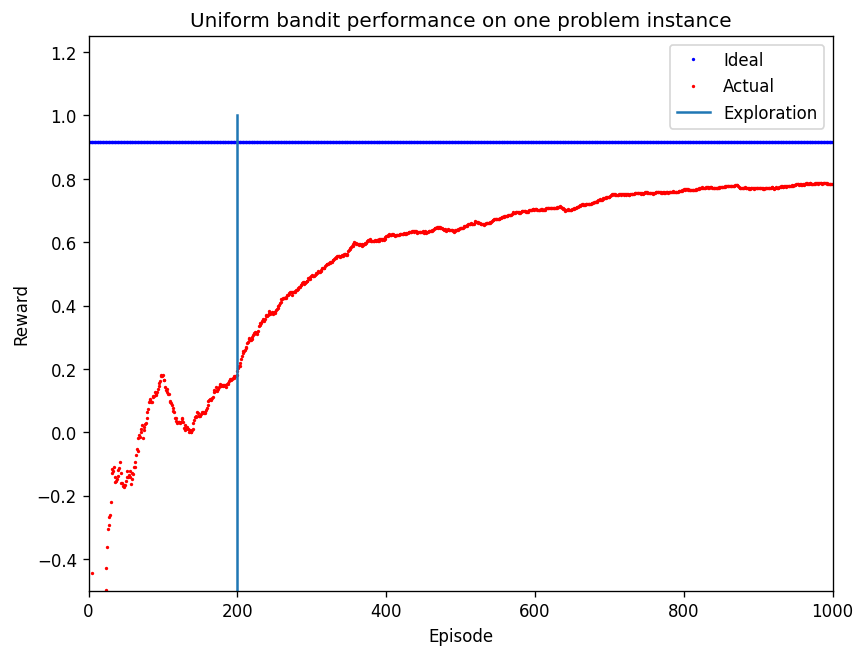

In [7]:
# plotting this one
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, 'bo', markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, 'ro', markersize=1)
ax.plot([uniform_bandit.exploration_episodes,
         uniform_bandit.exploration_episodes], [-0.5, 1])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual", "Exploration"])
plt.title("Uniform bandit performance on one problem instance")
plt.plot()

In [8]:
# config for this one
instances = 100
arms = 10
episodes = 1000
w = 25

accumulated_history_of_mean_rewards = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards = np.zeros(episodes)

uniform_bandit = None
times_best_arm_found = 0

for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance = kArmedBandit(means, variances)
  uniform_bandit = UniformBanditAlgorithm(instance, w)
  uniform_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards = accumulated_history_of_ideal_mean_rewards + instance.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards = accumulated_history_of_mean_rewards + instance.history_of_mean_rewards

  if uniform_bandit.best_arm == np.argmax(instance.true_means):
    times_best_arm_found += 1

print(f"Times best arm found {times_best_arm_found}/{instances}")

Times best arm found 65/100


[]

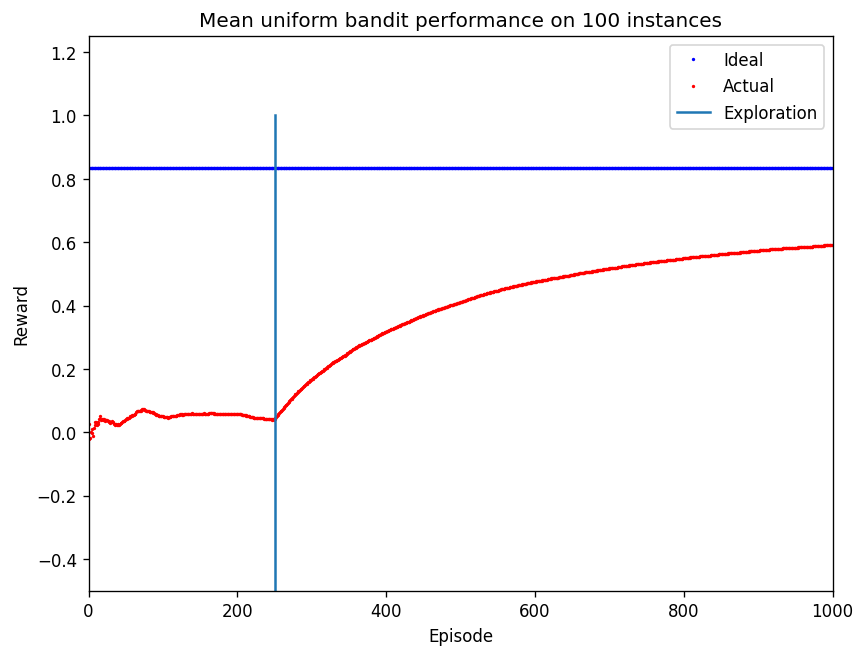

In [9]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance.total_plays)
p1 = ax.plot(accumulated_history_of_ideal_mean_rewards / instances, 'bo', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards / instances, 'ro', markersize=1)
ax.plot([uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes], [-0.5, 1])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual", "Exploration"])

plt.title(f"Mean uniform bandit performance on {instances} instances")

plt.plot()

In [10]:
class EpsilonGreedyAlgorithm:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.q_values = np.zeros(k)
        self.action_counts = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.q_values)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

    def get_estimates(self):
        return self.q_values

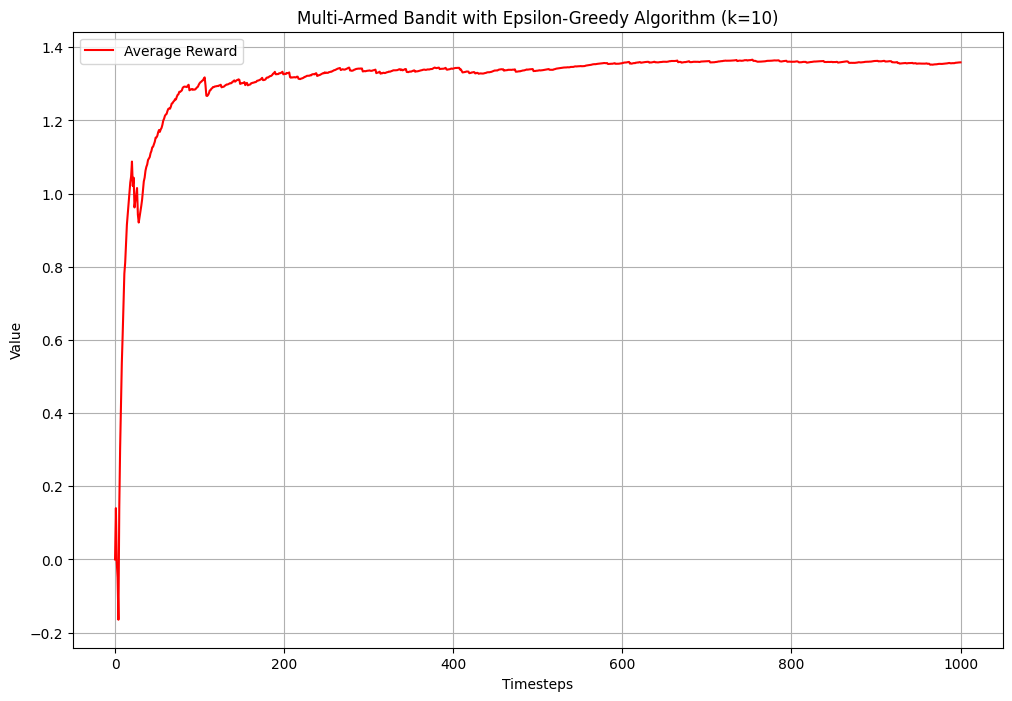

In [19]:
k=10
epsilon = 0.1
agent = EpsilonGreedyAlgorithm(k, epsilon)
instances = 1000
rewards = [0]
for _ in range(instances):
    true_rewards = [np.random.normal(0.24, 0.2), np.random.normal(-0.75, 0.2),
                    np.random.normal(1.5, 0.2),np.random.normal(0.49, 0.2),
                    np.random.normal(1.22, 0.2),np.random.normal(-1.5, 0.2),
                    np.random.normal(-0.14, 0.2),np.random.normal(-1.11, 0.2),
                    np.random.normal(0.68, 0.5),np.random.normal(-0.34, 0.2)]
    action = agent.select_action()
    reward = true_rewards[action]
    agent.update(action, reward)
    rewards.append(reward)
    

plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards) + 1), label="Average Reward", color="red")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.title("Multi-Armed Bandit with Epsilon-Greedy Algorithm (k=10)")
plt.legend(loc="best")
plt.grid()
plt.show()